In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import ipyvolume as ipv
%matplotlib inline

from tyssue import config
from tyssue.draw import sheet_view

from tyssue import Epithelium, BulkGeometry, config
from tyssue.generation import from_3d_voronoi, hexa_grid3d
from scipy.spatial import Voronoi

cells = hexa_grid3d(6, 6, 6)
datasets = from_3d_voronoi(Voronoi(cells))
specs = config.geometry.bulk_spec()
bulk = Epithelium('bulk', datasets, specs)
bulk.reset_topo()
bulk.reset_index()
bulk.sanitize()

BulkGeometry.update_all(bulk)

ipv.clear()
fig2, mesh = sheet_view(bulk, mode='3D', 
                       edge={'color': 'k'},
                       face={'visible': True,
                             'color': bulk.face_df.area})
fig2

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [17]:
from tyssue.dynamics import model_factory, effectors

In [18]:
model = model_factory(
    [effectors.CellVolumeElasticity,
     effectors.SurfaceTension]
    )


In [19]:
effectors.CellVolumeElasticity.specs

{'cell': {'is_alive': 1,
  'vol': 1.0,
  'vol_elasticity': 1.0,
  'prefered_vol': 1.0}}

In [20]:
specs = {
    "face": 
        {
            "surface_tension": 0.5,
        },
    "cell":
    {
        "prefered_vol": 1.0,
        "vol_elasticity": 14,
    }
}

bulk.update_specs(specs, reset=True)

bulk.get_opposite_faces()

no_opposite = bulk.face_df.query("opposite == -1").index

bulk.face_df.loc[no_opposite, "surface_tension"] = 0.7

In [21]:
from tyssue.solvers.quasistatic import QSSolver

In [22]:
solver = QSSolver()

solver.find_energy_min(bulk, BulkGeometry, model, options={"ftol":1e-8, "gtol":1e-7})



/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/tyssue-0.3.3-py3.7-linux-x86_64.egg/tyssue/dynamics/factory.py:85: UserWarning: setting ucoords in grad computation,please fix your specs
  "setting ucoords in grad computation," "please fix your specs"


      fun: 353.6503923117582
 hess_inv: <1740x1740 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00600723, -0.04412975,  0.05844356, ..., -0.01000018,
        0.01710981, -0.0205932 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 272
      nit: 134
   status: 0
  success: True
        x: array([2.48608707, 1.01660657, 0.4424385 , ..., 4.0515915 , 3.74484733,
       3.86596709])

In [23]:
bulk.get_opposite_faces()


In [24]:
from tyssue.draw import highlight_cells

In [41]:
ipv.clear()
bulk.face_df["visible"] = False
highlight_cells(bulk, 0)

fig2, mesh = sheet_view(bulk, mode='3D', 
                       edge={'color': 'k'},
                       face={'visible': True,
                
                             'color': bulk.face_df.area})
fig2

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [32]:
extra_cols

{'edge': [('sx', 'tx', 'fx'), ('sy', 'ty', 'fy'), ('sz', 'tz', 'fz')]}

In [38]:
from tyssue import History
extra_cols = {"edge": ['sx', 'tx', 'fx', 'cx', 'nx',
                       'sy', 'ty', 'fy', 'cy', 'ny',
                       'sz', 'tz', 'fz', 'cz', 'nz']}

history = History(bulk, extra_cols=extra_cols)


dt = 0.01
bulk.cell_df.loc[0, 'prefered_vol'] *= 2
bulk.vert_df['friction']  = 1.

for t in range(1):
    force = - model.compute_gradient(bulk)
    bulk.vert_df[bulk.coords] += (
        force.values / bulk.vert_df['friction'].values[:, np.newaxis]) * dt
    BulkGeometry.update_all(bulk)
    history.record(['vert', 'edge'])


In [40]:
from ipywidgets import interact

fig = plt.figure(2)

def player(t):
    plt.figure(2)
    ax = plt.gca()
    bulk = Epithelium(t, history.retrieve(t))
    BulkGeometry.update_all(bulk)
    ax.clear()
    _ = sheet_view(bulk, mode='quick', ax=ax)
    fig.canvas.draw()
    
interact(player, t=(0, 99))

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=49, description='t', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.player(t)>

(40, 50) yd.shape is 1st entry!
(40, 50)


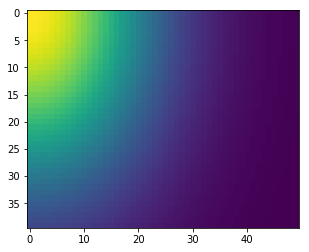

In [48]:
import numpy as np                                                                    
from scipy.interpolate import RectBivariateSpline                                      

xd = np.arange(50)
yd = np.arange(40)
                                                                     
# here order of coordinates is preserved                                              
xx, yy = np.meshgrid(xd, yd)                                                            
print(xx.shape, 'yd.shape is 1st entry!')                                              
                                                                                       
func2d = lambda x, y: np.exp(- (x**2/500 + y**2/1000) )                                
                                                                                       
data_on_grid = func2d(xx, yy)
# shape preserved, x -> xd and y -> yd
print(data_on_grid.shape)

# optional plotting
import matplotlib.pyplot as plt
plt.imshow(data_on_grid)

# interpolation                                                                        
# here the x from the docs needs to be set to the yd!                                  
# swapping of x = yd and y = xd?!                                                      
biv_spl = RectBivariateSpline(yd, xd, data_on_grid)

# throws error as dimensions not match!                                                
try:                                                                                  
    biv_spl = RectBivariateSpline(xd, yd, data_on_grid.T)                                
except ValueError as e:
    print(e)

In [43]:
RectBivariateSpline?

In [46]:
biv_spl = RectBivariateSpline(xx.ravel(), yy.ravel(), data_on_grid.ravel())                                    


ValueError: x must be strictly increasing